## EUKulele tuneR

Tutorial below details usage of EUKulele results in R. Specifically, compiling output files for downstream analysis and providing R functions to explore results.

### Import estimated-taxonomy outputs from EUKulele

Input requires files from ```/taxonomic_estimation``` directory from EUKulele

Enable a working R environment and load required libraries.

In [146]:
library(tidyverse); library(cowplot); library(ggalluvial)

In [147]:
# Import EUKulele output from running NB database with MMETSP
mmetsp_dia_nb <- read.delim("/vortexfs1/omics/alexander/shu/eukulele-test/mmetsp-diamond/nb-output-20-10/taxonomy_estimation/merged_merged-estimated-taxonomy.out")
head(mmetsp_dia_nb[1:2,])

X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous
0,megahit_NarBay_A_megahit_NarBay_A_k111_0,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema grethea,Skeletonema grethea,100.0,0
0,megahit_NarBay_A_megahit_NarBay_A_k111_10,species,Hacrobia; Haptophyta; Prymnesiophyceae; Prymnesiales; Chrysochromulinaceae; Chrysochromulina; Chrysochromulina ericina,Chrysochromulina ericina,95.5,0


In the above example data, EUKulele was run using the default MMETSP database and DIAMOND. Salmon counts were not incorporated into the EUKulele analysis, so each line represents a transcript from a metatranscriptome assembly. Since this includes over 6 million lines/transcripts, the R code below demonstrates examples of how to parse this data.

In [148]:
dim(mmetsp_dia_nb)

[1] 6110375       7

### R functions to process EUKulele results

For each sample, what are the total number of contigs with ambiguous matches? and how many contigs were assigned to the different taxonomic classification levels?

In [149]:
# Execute this function in R.
## Usage:
# eukulele_stats_mmetsp(df) - df = input taxonomy estimation dataframe from EUKulele run with MMETSP
## Output: reports total number of contigs assigned to each taxonomic group
eukulele_stats_mmetsp <- function(df_tax_est){
    df_tax_est %>% 
        summarise(Total_contigs = n_distinct(transcript_name),
                  Num_ambig = sum(ambiguous == 1),
                SUPERGROUP = sum(str_count(classification_level, "supergroup")),
                 CLASS = sum(str_count(classification_level, "class")),
                 FAMILY = sum(str_count(classification_level, "family")),
                 ORDER = sum(str_count(classification_level, "order")),
                 GENUS = sum(str_count(classification_level, "genus")),
                 SPECIES = sum(str_count(classification_level, "species")),
                 Distinct_tax_ids = n_distinct(full_classification)) %>% 
        data.frame
    }

In [150]:
eukulele_stats_mmetsp(mmetsp_dia_nb)

Total_contigs,Num_ambig,SUPERGROUP,CLASS,FAMILY,ORDER,GENUS,SPECIES,Distinct_tax_ids
6110176,413796,8256,711632,1270798,1186377,1246361,1571852,832


In [151]:
# For each sample, how many contigs were assigned to various classification levels?
plot_classification <- function(df_tax_est, name){
        df_tax_est  %>% 
        replace_na(list(counts = 1)) %>% 
        add_column(Sample = name) %>%
        add_column(counts = 1) %>% 
        group_by(Sample, classification_level) %>% 
        summarise(SUM_classification_level = sum(counts)) %>% 
    ggplot(aes(x = Sample, y = SUM_classification_level, fill = classification_level)) +
        geom_bar(stat = "identity", color = "black") +
        coord_flip() +
        theme_minimal() +
        theme(legend.position = "bottom", legend.title = element_blank())       
}

`summarise()` regrouping output by 'Sample' (override with `.groups` argument)


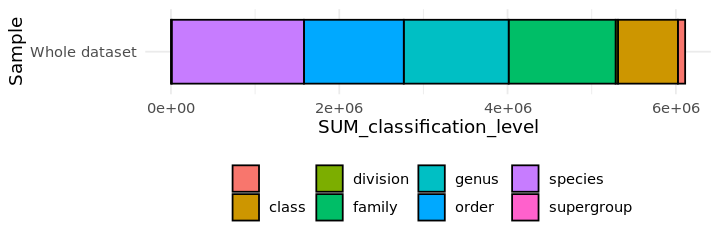

In [152]:
options(repr.plot.width = 6, repr.plot.height = 2) # Set plot output space
plot_classification(mmetsp_dia_nb, "Whole dataset")

If you have a data table with counts across samples that corresponds to the transcript names, this can be joined with the EUKulele outputs to visualize the taxonomy assignments. In this case, you can add the taxonomy identifiers to your count table. Use the function below, where ```SAMPLE``` equals your sample IDs and ```COUNT``` represents the relevent counts.

An alterative is to use EUKulele's built in incorporation of Salmount count data with the option ```--use_salmon_counts```. 

### Combine multiple EUKulele outputs

Tell R where your EUKulele output directory is located. This function will import each file and compile into one dataframe.

In [153]:
## If in your current directory:
# euk_out <- file.path("PATH/TO/EUKULELE/OUTPUTDIR")
# Example:
euk_out <- file.path("/vortexfs1/omics/alexander/shu/eukulele-test/mmetsp-diamond/nb-output/")

## If located in your current directory use this:
# euk_out <- getwd()

Once the location of your output EUKulele directory is located, the below commmands will list the files that the R function will locate and compile. In the case below, I have identified 13 taxonomy.out files from EUKulele. The next step is to join these together.

In [154]:
file_list <- list.files(pattern = "estimated-taxonomy.out", 
                            path = file.path(euk_out, "taxonomy_estimation"), 
                            full.names = FALSE)
writeLines(paste("Found", file_list))

Found SRR1810204_merged-estimated-taxonomy.out
Found SRR1810205_merged-estimated-taxonomy.out
Found SRR1810206_merged-estimated-taxonomy.out
Found SRR1810207_merged-estimated-taxonomy.out
Found SRR1810208_merged-estimated-taxonomy.out
Found SRR1810209_merged-estimated-taxonomy.out
Found SRR1810210_merged-estimated-taxonomy.out
Found SRR1810211_merged-estimated-taxonomy.out
Found SRR1810799_merged-estimated-taxonomy.out
Found SRR1810801_merged-estimated-taxonomy.out
Found SRR1945044_merged-estimated-taxonomy.out
Found SRR1945045_merged-estimated-taxonomy.out
Found SRR1945046_merged-estimated-taxonomy.out


The loop below will import each of the taxonomy.out files in your directory, parse the sample name (by "-") and compile the output into a single data frame called ```compiled_est_tax```

In [155]:
for (a in file_list){
        if(!exists("compiled_est_tax")){
            df_in <- read.delim(file.path(euk_out, "taxonomy_estimation", a)) # Import
            names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
            df_in$SAMPLE <- names[1] # Add sample name in column
            writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
            compiled_est_tax <- df_in # Generate final taxonomy table
            rm(df_in) # Clean up excess tmp df
        }
        if(exists("compiled_est_tax")){
            df_in <- read.delim(file.path(euk_out, "taxonomy_estimation", a)) # Import
            names <- unlist(strsplit(a, "-estimated-taxonomy.out")) # Isolate sample name
            df_in$SAMPLE <- names[1] # Add sample name in column
            writeLines(paste("Imported", names[1], "added", dim(df_in)[1], "identities."))
            compiled_est_tax <- rbind(compiled_est_tax, df_in) # Add to exisiting dataframe
            rm(df_in) # Clean up excess tmp df
        }
    }
# Output message notes which file has been added and compiled.

Imported SRR1810204_merged added 209 identities.
Imported SRR1810205_merged added 249 identities.
Imported SRR1810206_merged added 298 identities.
Imported SRR1810207_merged added 169 identities.
Imported SRR1810208_merged added 85 identities.
Imported SRR1810209_merged added 143 identities.
Imported SRR1810210_merged added 343 identities.
Imported SRR1810211_merged added 129 identities.
Imported SRR1810799_merged added 220 identities.
Imported SRR1810801_merged added 294 identities.
Imported SRR1945044_merged added 426 identities.
Imported SRR1945045_merged added 63 identities.
Imported SRR1945046_merged added 84 identities.


In [156]:
# Now the output compiled dataframe has a column called "SAMPLE".
head(compiled_est_tax[1:3,])

X,transcript_name,classification_level,full_classification,classification,max_pid,ambiguous,SAMPLE
0,megahit_SRR1810204_k71_10,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema marinoi,Skeletonema marinoi,100,0,SRR1810204_merged
0,megahit_SRR1810204_k71_100,genus,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema,Skeletonema,100,1,SRR1810204_merged
0,megahit_SRR1810204_k71_101,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema marinoi,Skeletonema marinoi,100,0,SRR1810204_merged


Now I can use a modified function from above to group my output taxonomy files by sample.

In [157]:
# For each sample, how many contigs were assigned to various classification levels?
plot_classification_wsamples <- function(df_tax_est){
        df_tax_est  %>% 
        group_by(SAMPLE, classification_level) %>% 
        add_column(COUNTS = 1) %>% # Comment out if a COUNTS column already exists
        summarise(SUM_classification_level = sum(COUNTS)) %>% 
    ggplot(aes(x = SAMPLE, y = SUM_classification_level, fill = classification_level)) +
        geom_bar(stat = "identity", color = "black") +
        coord_flip() +
        theme_minimal() +
        theme(legend.position = "bottom", legend.title = element_blank())       
}

`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)


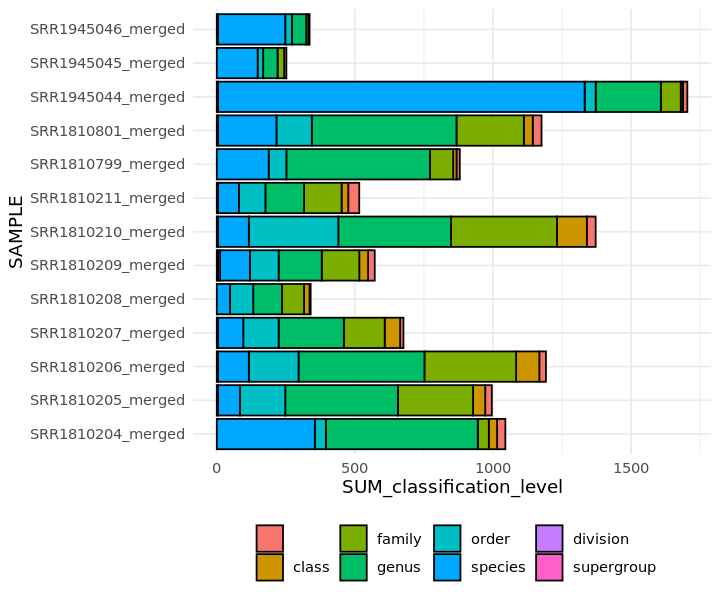

In [158]:
options(repr.plot.width = 6, repr.plot.height = 5) # Set plot output space
plot_classification_wsamples(compiled_est_tax)

### Parse taxonomic classifications & plot

Modify the functions below to plot results from each sample by different taxonomic groups. The examples below all use EUKulele outputs where the MMETSP database was used. The two functions below separate the classification columns from the EUKulele outputs and place them into separate columns. They are currently written to work with MMETSP or phylodb, but can be easily modified.

In [159]:
# Create a dataframe with parsed classification
## Usage: parse_mmetps(df) - df = input dataframe with column called "full_classification"
parse_mmetsp <- function(df_est) {
    df_out <- df_est %>% 
        separate(full_classification, 
                 c("Supergroup", "Class", "Family", "Order", "Genus", "Species"), 
                 sep = ";", remove = FALSE) %>% 
        data.frame
    return(df_out)
    }

In [160]:
# Separate phylodb 'taxonomy' column into separate columns
parse_phylodb <- function(df_est) {
    df_out <- df_est %>%
        separate(taxonomy, c("Domain","Phylum","Class","Order","Family","Genus","Species"), sep = ";", extra = "merge", remove = FALSE) %>% 
    data.frame
    return(df_out)
    }

Example usage, where I take my compiled dataset with EUKulele taxonomy classifications and parse.

In [161]:
df_parsed_compiled <- parse_mmetsp(compiled_est_tax)
head(df_parsed_compiled[1:2,])

Warning message:
“Expected 6 pieces. Additional pieces discarded in 3103 rows [1, 3, 11, 13, 19, 20, 25, 28, 32, 35, 36, 39, 42, 49, 50, 51, 53, 54, 55, 60, ...].”Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 4112 rows [4, 5, 6, 9, 15, 16, 18, 23, 24, 26, 31, 62, 72, 77, 87, 103, 109, 118, 124, 143, ...].”

X,transcript_name,classification_level,full_classification,Supergroup,Class,Family,Order,Genus,Species,classification,max_pid,ambiguous,SAMPLE
0,megahit_SRR1810204_k71_10,species,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema; Skeletonema marinoi,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema marinoi,100,0,SRR1810204_merged
0,megahit_SRR1810204_k71_100,genus,Stramenopiles; Ochrophyta; Bacillariophyta; Bacillariophyta_X; Polar-centric-Mediophyceae; Skeletonema,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophyta_X,Polar-centric-Mediophyceae,Skeletonema,Skeletonema,100,1,SRR1810204_merged


Now we can use the below functions to plot our results at different taxonomic levels.

In [162]:
# Function to plot at chosen taxonomic level
## Usage:
# plot_mmetsp_atlevel(df, level) - df=input dataframe, and level=column name of taxonomic level to visualize results.
plot_mmetsp_atlevel <- function(df_in, level){
    LEVEL <- enquo(level)
    out <- df_in %>% 
        type.convert(as.is = TRUE) %>%
        group_by(!!LEVEL, SAMPLE) %>% 
        add_column(COUNT = 1) %>% 
        summarise(SUM = sum(COUNT)) %>% 
        data.frame
    ggplot(out, aes(x = SAMPLE, fill = !!LEVEL, y = SUM)) +
        geom_bar(stat = "identity", color = "black") +
        coord_flip() +
        theme_minimal()
}

In [163]:
# Make sure to used a data frame with taxonomy parsed apart.
colnames(df_parsed_compiled)

[1] "X"                    "transcript_name"      "classification_level"
 [4] "full_classification"  "Supergroup"           "Class"               
 [7] "Family"               "Order"                "Genus"               
[10] "Species"              "classification"       "max_pid"             
[13] "ambiguous"            "SAMPLE"

`summarise()` regrouping output by 'Class' (override with `.groups` argument)


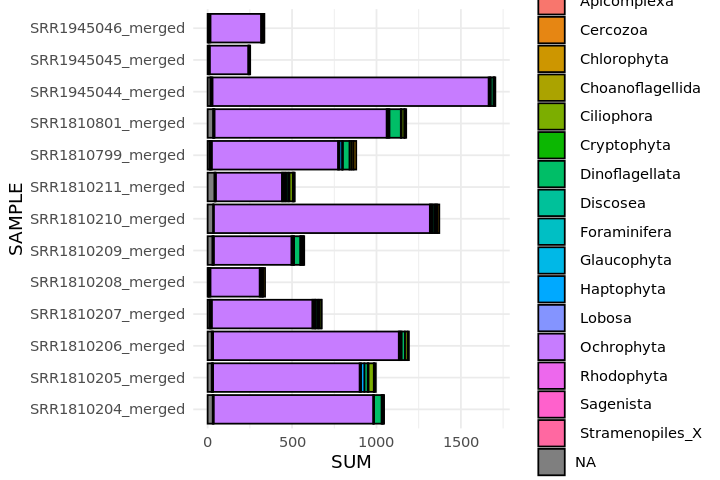

In [164]:
options(repr.plot.width = 6, repr.plot.height = 4) # Set plot output space
plot_mmetsp_atlevel(df_parsed_compiled, Class)

### EUKulele provided databases
Since EUKulele will determine taxonomic assignment for provided sequence data, you can retrieve those databases ahead of time if needed (or create your own). By default EUKulele will download and use MMETSP. Options for databases include: MMETSP (```mmetsp```), PhyloDB (```phylodb```), Eukprot (```eukprot```), or EukZoo (```eukzoo```). To only download the database, run the following command:

```
# Within the EUKulele conda environment
EUKulele download --reference_dir phylodb
```

In [165]:
setwd("/vortexfs1/omics/alexander/shu/db")
# IMPORT
mmetsp <- read.delim("mmetsp/tax-table.txt")
phylodb <- read.delim("phylodb/tax-table.txt")
eukprot <- read.delim("eukprot/tax-table.txt")
eukzoo <- read.delim("eukzoo/taxonomy-table.txt")

Use the below functions to get database stats and search each EUKulele provided database.

In [166]:
# Prints contents of a database.
db_stats <- function(db_df){
    writeLines(paste(dim(db_df)[1], "total entries in database."))
    # EUKulele taxonomic level designations:
    tld <- c("Strain", "Supergroup", "Division", "Class", "Order", "Family", "Genus", "Species",
            "Genus_UniEuk", "Epithet_UniEuk", "Supergroup_UniEuk", "Taxogroup_UniEuk")
#     tmp <- db_df %>% 
#         select((tld))
    tmp_avail <- names(db_df)[names(db_df) %in% tld]
    tmp <- db_df[, tmp_avail]
    as.character(unique(tmp$Supergroup))
    writeLines(paste("Total unique strains", length(unique(tmp$Strain))))
    writeLines(paste("Total unique species", length(unique(tmp$Species))))
}

Example usage:

In [167]:
db_stats(mmetsp)

678 total entries in database.
Total unique strains 405
Total unique species 316


In [168]:
db_stats(eukzoo)

739 total entries in database.
Total unique strains 441
Total unique species 361


In [169]:
# Function to search database for taxa of interest
## Uses regular expression in string
## set equal to new R object to save list
db_search <- function(db_df, query_tax, output){
    out <- db_df %>% 
        filter_all(any_vars(str_detect(., pattern = query_tax))) %>% 
        data.frame
    writeLines(paste("Found", dim(out)[1], "matching IDs"))
    return(out)
}

Example usage is to ask: *How many Dictyochophyceae entries are present in the MMETSP database versus the EukZoo database?*

The output prints the total number of entries matching your query search text and prints the output. If you save the command to a new dataframe, it will save the results.

In [170]:
mmetsp_dictyocho <- db_search(mmetsp, "Dicty")
head(mmetsp_dictyocho)

Found 14 matching IDs


X,CYVERSE_PATH,Source_ID_dup,REF_STATUS,Source_ID,Strain,Supergroup,Division,Class,Order,Family,Genus,Species,Notes
609,2496,MMETSP1174,Clean,MMETSP1174,CCMP1381,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Dictyochales,Dictyocha,Dictyocha speculum,"Guillou L., Vaulot D., PhytoRef (PR2)"
610,2108,MMETSP1323,Clean,MMETSP1323,RCC1693,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Florenciellales,Florenciella,Florenciella parvula,"Guillou L., Vaulot D., PhytoRef (PR2)"
611,2152,MMETSP1344,Clean,MMETSP1344,CCMP2471,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Florenciellales,Florenciella,Florenciella parvula,"Guillou L., Vaulot D., PhytoRef (PR2)"
612,2114,MMETSP1324,Clean,MMETSP1324,RCC1587,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Florenciellales,Florenciella,Florenciella sp.,"Guillou L., Vaulot D., PhytoRef (PR2)"
613,2468,MMETSP1325,Clean,MMETSP1325,RCC1007,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Florenciellales,Florenciella,Florenciella sp.,"Guillou L., Vaulot D., PhytoRef (PR2)"
614,1899,MMETSP1068,Clean,MMETSP1068,CCMP716,Stramenopiles,Ochrophyta,Dictyochophyceae,Dictyochophyceae_X,Pedinellales,Pseudopedinella,Pseudopedinella elastica,"Guillou L., Vaulot D., PhytoRef (PR2)"


In [171]:
eukzoo_dictyocho <- db_search(eukzoo, "Dicty")
head(eukzoo_dictyocho)

Found 12 matching IDs


Source_ID,Strain,Supergroup,Phylum,Class,Order,Family,Genus,Species,Notes
MMETSP1174,CCMP1381,Stramenopile,Ochrophyta,Dictyochophyceae,Dictyochales,Dictyochaceae,Dictyocha,Dictyocha speculum,"Ehrenberg, 1839"
MMETSP1323,RCC1693,Stramenopile,Ochrophyta,Dictyochophyceae,Florenciellales,Incertae sedis,Florenciella,Florenciella parvula,"Eikrem, 2004"
MMETSP1344,CCMP2471,Stramenopile,Ochrophyta,Dictyochophyceae,Florenciellales,Incertae sedis,Florenciella,Florenciella parvula,"Eikrem, 2004"
MMETSP1324,RCC1587,Stramenopile,Ochrophyta,Dictyochophyceae,Florenciellales,Incertae sedis,Florenciella,Florenciella sp.,"Eikrem, 2004"
MMETSP1325,RCC1007,Stramenopile,Ochrophyta,Dictyochophyceae,Florenciellales,Incertae sedis,Florenciella,Florenciella sp.,"Eikrem, 2004"
MMETSP1068,CCMP716,Stramenopile,Ochrophyta,Dictyochophyceae,Pedinellales,Pedinellaceae,Pseudopedinella,Pseudopedinella elastica,"Skuja, 1948"


In the above examples there were 14 and 12 entired in the MMETSP and EukZoo databases, respectively. Each were saved to an output dataframe.

`summarise()` regrouping output by 'LEVELS' (override with `.groups` argument)


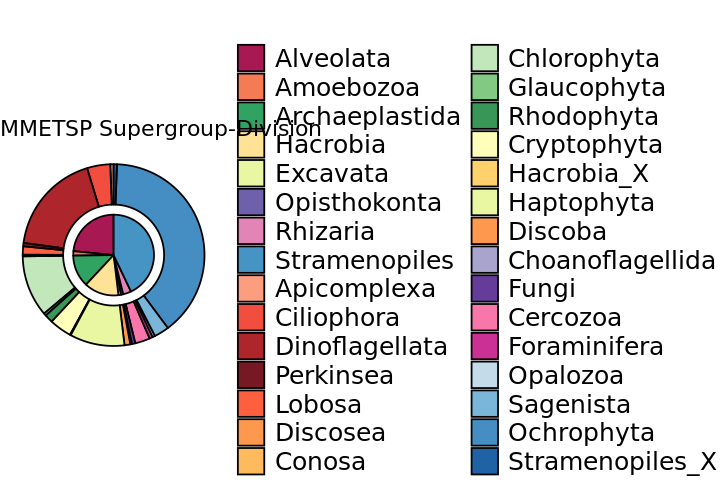

In [172]:
# Visualize contents of MMETSP database
# Prep mmetsp database to plot distribution
tld <- c("Strain", "Supergroup", "Division", "Class", "Order", "Family", "Genus", "Species",
            "Genus_UniEuk", "Epithet_UniEuk", "Supergroup_UniEuk", "Taxogroup_UniEuk")
mmetsp_plot <- mmetsp %>% 
    select(any_of(tld))

#Factor & prep
super_div <- mmetsp %>% 
    select(Supergroup, Division) %>% 
    add_column(freq = 1) %>% 
    pivot_longer(cols = c(Supergroup, Division), names_to = "LEVELS") %>%
    group_by(LEVELS, value) %>% 
    summarise(FREQ = sum(freq)) %>% 
    arrange(LEVELS) %>% 
    data.frame
div_order <- c("Alveolata","Amoebozoa","Archaeplastida","Hacrobia",
               "Excavata","Opisthokonta","Rhizaria","Stramenopiles",
               "Apicomplexa","Ciliophora","Dinoflagellata","Perkinsea",
               "Lobosa","Discosea","Conosa","Chlorophyta","Glaucophyta",
               "Rhodophyta","Cryptophyta","Hacrobia_X","Haptophyta", "Discoba",
               "Choanoflagellida","Fungi","Cercozoa","Foraminifera","Opalozoa",
               "Sagenista","Ochrophyta","Stramenopiles_X")
col_order <- c("#9e0142","#f46d43","#1a9850","#fee08b",
               "#e6f598","#5e4fa2","#de77ae","#3288bd",
               "#fc9272","#ef3b2c","#a50f15","#67000d",
               "#fc4e2a","#fd8d3c","#feb24c","#bae4b3","#74c476","#238b45",
               "#ffffb2","#fecc5c","#e6f598","#fd8d3c","#9e9ac8","#54278f",
               "#f768a1","#c51b8a","#bdd7e7","#6baed6","#3182bd","#08519c")
super_div$DIVISION <- factor(super_div$value, levels = div_order)
super_div$LEVELS_ORDER <- factor(super_div$LEVELS, levels = c("Supergroup", "Division"))
names(div_order) <- col_order

# plot
ggplot(super_div, aes(x = LEVELS_ORDER, fill = DIVISION, y = FREQ)) +
            geom_bar(stat = "identity", position = "stack", color = "black", alpha = 0.9, width = c(0.8)) +
            coord_polar("y", start = 0) +
            scale_fill_manual(values = col_order) +
            theme_void() +
            theme(legend.title = element_blank(),
                 legend.text = element_text(size = 15)) +
            labs(title = "MMETSP Supergroup-Division")

`summarise()` ungrouping output (override with `.groups` argument)


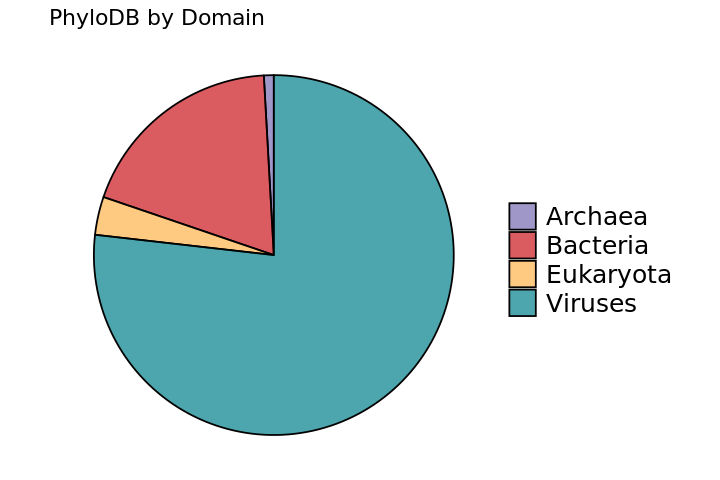

In [173]:
# PhyloDB at domain level
phylodb %>% 
    select(Supergroup) %>% 
    add_column(freq = 1) %>% 
    group_by(Supergroup) %>% 
    summarise(FREQ = sum(freq)) %>% 
    pivot_longer(cols = c(Supergroup), names_to = "LEVELS") %>%
        ggplot(aes(x = LEVELS, fill = value, y = FREQ)) +
            geom_bar(stat = "identity", position = "stack", color = "black", alpha = 0.7) +
            scale_fill_manual(values = c("#756bb1", "#cb181d", "#feb24c", "#02818a")) +
            coord_polar("y", start = 0) +
            theme_void() +
            theme(legend.title = element_blank(),
                 legend.text = element_text(size = 15)) +
            labs(title = "PhyloDB by Domain")

`summarise()` regrouping output by 'LEVELS' (override with `.groups` argument)


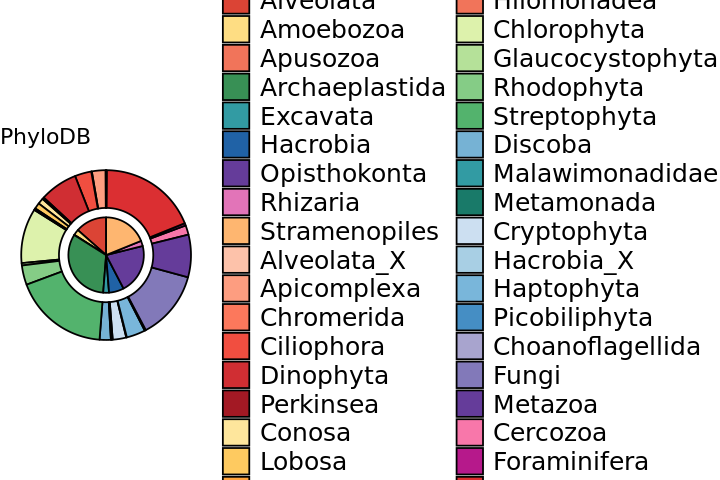

In [174]:
# prep phylodb database to plot
phylodb_div_class <- phylodb %>% 
  filter(Supergroup == "Eukaryota") %>% 
  select(Division, Class) %>% 
  add_column(freq= 1) %>% 
  pivot_longer(cols = c(Division, Class), names_to = "LEVELS") %>% 
  group_by(LEVELS, value) %>%
  summarise(FREQ = sum(freq)) %>%
  arrange(LEVELS) %>%
  data.frame
taxa_order <- c("Alveolata","Amoebozoa","Apusozoa","Archaeplastida","Excavata","Hacrobia","Opisthokonta","Rhizaria","Stramenopiles","Alveolata_X","Apicomplexa","Chromerida","Ciliophora","Dinophyta","Perkinsea","Conosa","Lobosa","Stereomyxa","Tubulinea","Hilomonadea","Chlorophyta","Glaucocystophyta","Rhodophyta","Streptophyta","Discoba","Malawimonadidae","Metamonada","Cryptophyta","Hacrobia_X","Haptophyta","Picobiliphyta","Choanoflagellida","Fungi","Metazoa","Cercozoa","Foraminifera","Stramenopiles_X","Synurophyceae")
color_order <- c("#d7301f","#fed976","#ef6548","#238443","#1c9099","#08519c","#54278f","#df65b0","#fdae61","#fcbba1","#fc9272","#fb6a4a","#ef3b2c","#cb181d","#99000d","#fee391","#fec44f","#fe9929","#ec7014","#ef6548","#d9f0a3","#addd8e","#78c679","#41ab5d","#67a9cf","#1c9099","#016c59","#c6dbef","#9ecae1","#6baed6","#3182bd","#9e9ac8","#756bb1","#54278f","#f768a1","#ae017e","#d7191c","#fdae61")
# head(phylodb_div_class)
phylodb_div_class$TAXA_ORDER <- factor(phylodb_div_class$value, levels = taxa_order)
phylodb_div_class$LEVELS_ORDER <- factor(phylodb_div_class$LEVELS, levels = c("Division", "Class"))
names(taxa_order) <- color_order

# Plot
ggplot(phylodb_div_class, aes(x = LEVELS_ORDER, fill = TAXA_ORDER, y = FREQ)) +
            geom_bar(stat = "identity", position = "stack", color = "black", alpha = 0.9, width = c(0.8)) +
            coord_polar("y", start = 0) +
            scale_fill_manual(values = color_order) +
            theme_void() +
            theme(legend.title = element_blank(),
                 legend.text = element_text(size = 15)) +
            labs(title = "PhyloDB")

`summarise()` regrouping output by 'LEVELS' (override with `.groups` argument)


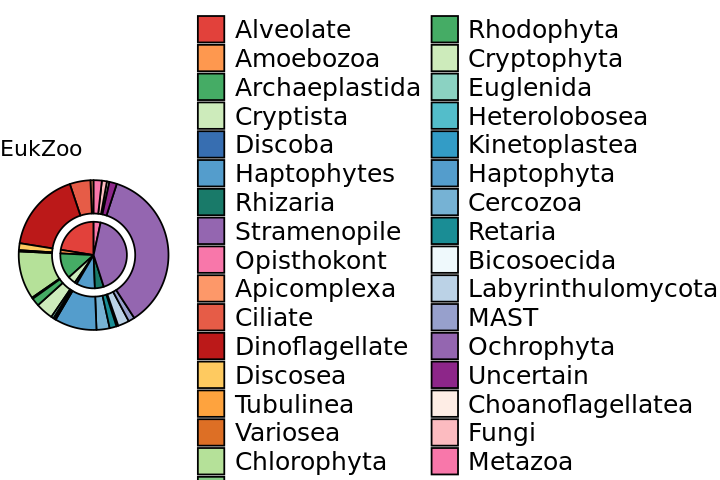

In [175]:
# EukZoo
zoo_div <- eukzoo %>% 
  select(Supergroup, Phylum) %>% 
  add_column(freq= 1) %>% 
  pivot_longer(cols = c(Supergroup, Phylum), names_to = "LEVELS") %>% 
  group_by(LEVELS, value) %>%
  summarise(FREQ = sum(freq)) %>%
  arrange(LEVELS) %>%
  data.frame
taxa_order <- c("Alveolate","Amoebozoa","Archaeplastida","Cryptista","Discoba","Haptophytes","Rhizaria","Stramenopile","Opisthokont","Apicomplexa","Ciliate","Dinoflagellate","Discosea","Tubulinea","Variosea","Chlorophyta","Glaucophyta","Rhodophyta","Cryptophyta","Euglenida","Heterolobosea","Kinetoplastea","Haptophyta","Cercozoa","Retaria","Bicosoecida","Labyrinthulomycota","MAST","Ochrophyta","Uncertain","Choanoflagellatea","Fungi","Metazoa")
color_order <- c("#de2d26","#fd8d3c","#31a354","#c7e9b4","#225ea8","#4292c6","#016c59","#8856a7","#f768a1","#fc8d59","#e34a33","#b30000","#fec44f","#fe9929","#d95f0e","#addd8e","#78c679","#31a354","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#4292c6","#67a9cf","#02818a","#edf8fb","#b3cde3","#8c96c6","#8856a7","#810f7c","#feebe2","#fbb4b9","#f768a1")
zoo_div$TAXA_ORDER <- factor(zoo_div$value, levels = taxa_order)
zoo_div$LEVELS_ORDER <- factor(zoo_div$LEVELS, levels = c("Supergroup", "Phylum"))
names(taxa_order) <- color_order

# plot
ggplot(zoo_div, aes(x = LEVELS_ORDER, fill = TAXA_ORDER, y = FREQ)) +
            geom_bar(stat = "identity", position = "stack", color = "black", alpha = 0.9, width = c(0.8)) +
            coord_polar("y", start = 0) +
            scale_fill_manual(values = color_order) +
            theme_void() +
            theme(legend.title = element_blank(),
                 legend.text = element_text(size = 15)) +
            labs(title = "EukZoo")

Warning message:
“Expected 6 pieces. Additional pieces discarded in 704 rows [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, ...].”Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 12 rows [3, 29, 162, 163, 320, 647, 648, 687, 688, 689, 690, 732].”`summarise()` regrouping output by 'LEVELS' (override with `.groups` argument)


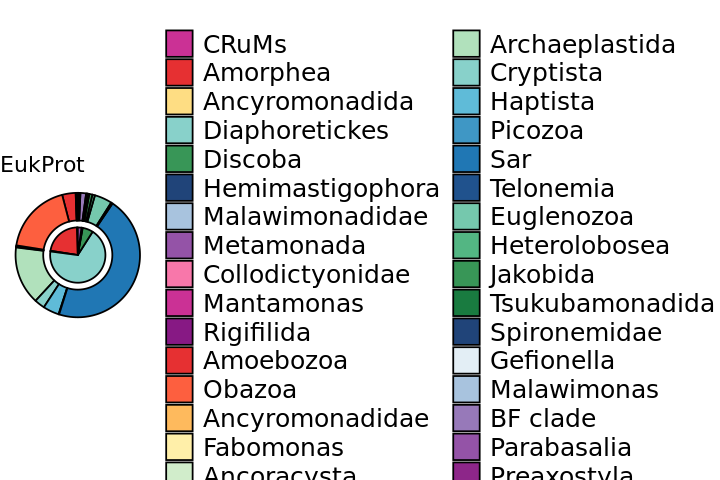

In [176]:
# EukProt
eukprot_div <- eukprot %>% 
  separate(Taxonomy_UniEuk, c("ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"), sep = ";") %>% 
    select(TWO, THREE) %>%  
  add_column(freq= 1) %>% 
  pivot_longer(cols = c(TWO, THREE), names_to = "LEVELS") %>%
  group_by(LEVELS, value) %>%
  summarise(FREQ = sum(freq)) %>%
  arrange(LEVELS) %>%
  mutate(value = case_when(
    grepl("CRuMs", value) ~ "CRuMs",
    grepl("BF clade", value) ~ "BF clade",
    TRUE ~ value
  )) %>% 
  data.frame

# Factor
tax_order <- c("CRuMs","Amorphea","Ancyromonadida","Diaphoretickes","Discoba","Hemimastigophora","Malawimonadidae","Metamonada","Collodictyonidae","Mantamonas","Rigifilida","Amoebozoa","Obazoa","Ancyromonadidae","Fabomonas","Ancoracysta","Archaeplastida","Cryptista","Haptista","Picozoa","Sar","Telonemia","Euglenozoa","Heterolobosea","Jakobida","Tsukubamonadida","Spironemidae","Gefionella","Malawimonas","BF clade","Parabasalia","Preaxostyla")
color_order <- c("#c51b8a","#e31a1c","#fed976","#7bccc4","#238b45","#08306b","#9ebcda","#88419d","#f768a1","#c51b8a","#7a0177","#e31a1c","#fc4e2a","#feb24c","#ffeda0","#ccebc5","#a8ddb5","#7bccc4","#4eb3d3","#2b8cbe","#0868ac","#084081","#66c2a4","#41ae76","#238b45","#006d2c","#08306b","#e0ecf4","#9ebcda","#8c6bb1","#88419d","#810f7c")
eukprot_div$TAXA_ORDER <- factor(eukprot_div$value, levels = tax_order)
eukprot_div$LEVELS_ORDER <- factor(eukprot_div$LEVELS, levels = c("TWO", "THREE"))
names(taxa_order) <- color_order

# Plot
ggplot(eukprot_div, aes(x = LEVELS_ORDER, fill = TAXA_ORDER, y = FREQ)) +
            geom_bar(stat = "identity", position = "stack", color = "black", alpha = 0.9, width = c(0.8)) +
            coord_polar("y", start = 0) +
            scale_fill_manual(values = color_order) +
            theme_void() +
            theme(legend.title = element_blank(),
                 legend.text = element_text(size = 15)) +
            labs(title = "EukProt")

In [177]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vortexfs1/home/sarahhu/anaconda3/envs/r_3.6.0/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggalluvial_0.12.2 cowplot_1.1.0     forcats_0.4.0     stringr_1.4.0    
 [5] dplyr_1.0.2       purrr_0.3.4       readr_1.3.1       tidyr_1.1.2      
 [9] tibble_3.0.3      ggplot2_3.3.2     tidyverse_1.2.1  

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       cellranger_1.1.0 pillar_1.4.6     compiler_3.6.1  
 [5] base64enc_0.1-3  tools_3.6.1      digest_0.6.18    uuid_0.1-2      
 [9] lubridate_1.7.4  jsonlite_1.6     evaluate_0.13    lifecycle_0.2.0 
[13] nlme_3.1-139     gtable_0.3.0     lattice_0.20-38  pkgconfig_2.0.2 
[17] rlang_0.4.7      cli_1.1.0        rstudioapi_0.10  IRdisplay_0.7.0 
[21] IR

**Last updated SKH Oct 2020**